In [18]:
# importing necessary libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

## Machine learning algorithms to perform classification

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier 
import xgboost as xgb
from xgboost import XGBClassifier


## performance metrics for classification
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
import warnings
warnings.filterwarnings('ignore')

In [3]:
#loading train and test datasets
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")

# Model Building

In [4]:
# Dropping the ID column as it doen't contribute to predicting custo,mer group
train_data.drop(columns='ID',inplace=True)

In [5]:
# encoding target column
train_data.Segmentation = train_data.Segmentation.map({'A':1,'B':2,'C':3,'D':4})
train_data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,4
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,1
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,2
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,2
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,1


In [6]:
# separating features and response variable

# storing target column in variable called y
y = train_data.Segmentation

# Storing all the columns otherthan target in variable called X
X = train_data.drop(columns = 'Segmentation')

In [89]:
## Splitting data : 80% for training and 20% for validation 
## random_state is set to 45 to get reproducible output across multiple function calls

X_train, X_validation, y_train, y_validation = train_test_split(X,y,
                                                                test_size=0.20,
                                                                random_state=45)

In [16]:
print("length of X_train :      ",len(X_train))
print("length of X_validation : ",len(X_validation))
print("length of y_train :      ",len(y_train))
print("length of y_validation:  ",len(y_validation))

length of X_train :       6454
length of X_validation :  1614
length of y_train :       6454
length of y_validation:   1614


# Creating machine learning models using SupportVectorClassifier, KNeighborsClassifier,LogisticReression and MLPClassifier algoritms¶

The following 3 steps will be common for all the models that are going to be built:

- step1 : Creating a pipeline for data preprocessing , pipeline contains an imputer and a scaler for numerical columns, imputer and onehotencoder for categorical columns.
- step2 : Defining a cross-validation stragtegy using StratifiedKFold crossvalidator
- step3 : Creating a function called gridsearch which takes a classifier, parameters for grid search and cross validator and returns the best estimator


In [8]:
## selecting all the columns whose data type is numerical - int, float
numerical_features = train_data.iloc[:,:-1].select_dtypes(include=['int64','float64']).columns

## selecting the columns whose datatype is categorical - object
categorical_features = train_data.iloc[:,:-1].select_dtypes(include=['object']).columns

## Creating a Pipeline that scales the data using Robustscaler on numerical features
numerical_transformer = Pipeline(steps = 
    [
        ('imputer', SimpleImputer(strategy='median')), # Imputation transformer for completing missing values
        ('scaler', RobustScaler()) # RoustScaler removes the median and scales the data according to the quantile range(defaults to Interquartile Range).
    ])

SimpleImputer()
## Creating a pipeline that encodes categorical features as one-hot numeric array & imputes null values with most frequent value in that column
categorical_transformer = Pipeline(steps=
     [
         ('imputer', SimpleImputer(strategy='most_frequent')),
         ('encoder', OneHotEncoder(drop='first'))
    ])

## Creating a fullpipeline which does both scaling and encoding on given data by combining the two pipelines created(numerical_transformer,categorical_transformer)
preprocess_pipe = ColumnTransformer(transformers = [
                                         ('numerical',numerical_transformer,numerical_features),
                                         ('categorical',categorical_transformer,categorical_features)
                                        ])


#The following Crossvalidation method will be used in all the models
# Kfold cross-validator with 5 folds
cv = StratifiedKFold(n_splits=5)

In [9]:
# step3: creating a function to perform gridsearch

def gridsearch(classifier, grid_params, cv):
    
    """This function takes a classifier, parameters for grid search and cross validator as arguments
    and returns the classifier with high accuracy"""
    
    ## estimator to gridsearch is a pipeline that performs data preprocesssing and applies a fit with the given classifier.
    model = GridSearchCV(
                            estimator  = Pipeline(steps =[('preprocess',preprocess_pipe),('classifier',classifier)]),
                            param_grid = grid_params,  # perform gridsearch on grid parameters given
                            scoring    = 'accuracy',   # accuracy is used as scoring metric
                            n_jobs     = -1,           # n_jobs = -1,uses all the processors
                            cv         = cv,
                            verbose    = 2
                       )
    model.fit(X_train,y_train) # Fitting the training data.
    return model

# Logistic Regression

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.4min finished


Best parameters :  {'classifier__C': 0.6158482110660264, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}  

Training Accuracy :    0.5071278199100511
Validation Accuracy :  0.5254027261462205 
 
Confusion Matrix: 
 [[194  53  68  76]
 [118  97 115  42]
 [ 63  54 235  50]
 [ 85  23  19 322]]
 
Classification Report : 
               precision    recall  f1-score   support

           1       0.42      0.50      0.46       391
           2       0.43      0.26      0.32       372
           3       0.54      0.58      0.56       402
           4       0.66      0.72      0.69       449

    accuracy                           0.53      1614
   macro avg       0.51      0.51      0.51      1614
weighted avg       0.52      0.53      0.52      1614



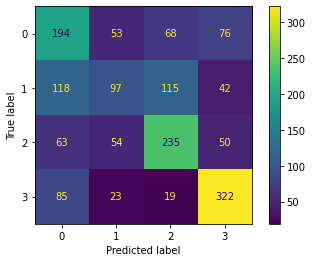

In [11]:
# Parameters for gridsearch
grid_parameters = { 
                    'classifier__penalty' :   ['l1', 'l2', 'elasticnet'],
                    'classifier__C'       :   np.logspace(-1, 2, 20),
                    'classifier__solver'  :   ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                  }


# Calling the function gridsearch with RandomForestClassifier,grid_parameters and Cross validator,saving the model in a variable.
model = gridsearch(LogisticRegression(random_state = 1),grid_parameters,cv)

## Printing best parameters given by gridsearch 
print("Best parameters : ", model.best_params_, " \n")

## printing train accuracy
print("Training Accuracy :   ", model.best_score_)

## Using the fitted model making predictions on validation data and stroring them in a variable called y_predicted.
y_predicted = model.best_estimator_.predict(X_validation)

## Calculating accuracy score on validation data
accuracy_logistic = accuracy_score(y_validation, y_predicted)
print("Validation Accuracy : ", (accuracy_logistic),  "\n ")

## priting confusion matrix to evaluate the accuracy of classification.
cm_logistic = confusion_matrix(y_validation, y_predicted)
print("Confusion Matrix: \n",cm_logistic)
disp = ConfusionMatrixDisplay(cm_logistic)
disp.plot()

## printing Classification Report: A text report showing the main classification metrics.
print(" ")
print("Classification Report : \n", classification_report(y_validation, y_predicted))   

## Saving the best estimator
Best_estimator_logistic=  model.best_estimator_

# SVC

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 56.6min finished


Best parameters :  {'classifier__C': 0.6158482110660264, 'classifier__gamma': 0.2782559402207126, 'classifier__kernel': 'rbf'}  

Training Accuracy :    0.5215384984898432
Validation Accuracy :  0.5421313506815365 
 
Confusion Matrix: 
 [[199  76  44  72]
 [100 146  91  35]
 [ 43  90 215  54]
 [101  24   9 315]]
 
Classification Report : 
               precision    recall  f1-score   support

           1       0.45      0.51      0.48       391
           2       0.43      0.39      0.41       372
           3       0.60      0.53      0.57       402
           4       0.66      0.70      0.68       449

    accuracy                           0.54      1614
   macro avg       0.54      0.53      0.53      1614
weighted avg       0.54      0.54      0.54      1614



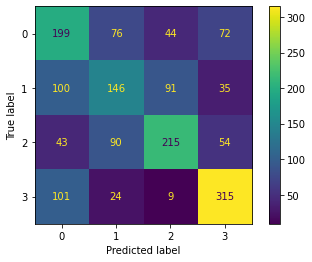

In [14]:
# Parameters for gridsearch
grid_parameters = {  
                   'classifier__C'     :        np.logspace(-1,2,20), 
                   'classifier__gamma' :        np.logspace(-5,5,10),
                   'classifier__kernel':        ['rbf','linear']
                  }

# Calling the function gridsearch with SupportVectorClassifier,grid_parameters and Cross validator,saving the model in a variable.
model = gridsearch(SVC(random_state = 1),grid_parameters,cv)

## Printing best parameters given by gridsearch 
print("Best parameters : ", model.best_params_, " \n")

## printing train accuracy
print("Training Accuracy :   ", model.best_score_)

## Making predictions on validation data
y_predicted = model.best_estimator_.predict(X_validation)

## Calculating accuracy score on validation data
accuracy_svc = accuracy_score(y_validation, y_predicted)
print("Validation Accuracy : ", (accuracy_svc),  "\n ")


## priting confusion matrix to evaluate the accuracy of classification.
cm_svc = confusion_matrix(y_validation, y_predicted)
print("Confusion Matrix: \n",cm_svc)
disp = ConfusionMatrixDisplay(cm_svc)
disp.plot()

## printing Classification Report: A text report showing the main classification metrics.
print(" ")
print("Classification Report : \n", classification_report(y_validation, y_predicted))       

## Saving the best estimator
Best_estimator_svc =  model.best_estimator_

# KNN 

Fitting 5 folds for each of 1836 candidates, totalling 9180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

Best parameters :  {'classifier__algorithm': 'ball_tree', 'classifier__leaf_size': 4, 'classifier__n_neighbors': 17, 'classifier__p': 1, 'classifier__weights': 'uniform'}  

Training Accuracy :    0.49426704855919634
Validation Accuracy :  0.49876084262701365 
 
Confusion Matrix: 
 [[160  92  73  66]
 [ 84 126 126  36]
 [ 43  85 226  48]
 [ 97  44  15 293]]
 
Classification Report : 
               precision    recall  f1-score   support

           1       0.42      0.41      0.41       391
           2       0.36      0.34      0.35       372
           3       0.51      0.56      0.54       402
           4       0.66      0.65      0.66       449

    accuracy                           0.50      1614
   macro avg       0.49      0.49      0.49      1614
weighted avg       0.50      0.50      0.50      1614



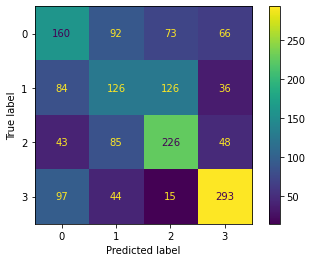

In [33]:
# Parameters for gridsearch
grid_parameters = { 
    
                   'classifier__algorithm'  :   ['ball_tree', 'kd_tree', 'brute'],
                   'classifier__leaf_size'  :   range(1,50,3),
                   'classifier__n_neighbors':   range(3,20,2), # odd numbers
                   'classifier__p'          :   [1,2],
                   'classifier__weights'    :   ['uniform', 'distance'] }

# Calling the function gridsearch with KNeighborsClassifier,grid_parameters and Cross validator,saving the model in a variable.
model = gridsearch(KNeighborsClassifier(),grid_parameters,cv)

## Printing best parameters given by gridsearch 
print("Best parameters : ", model.best_params_, " \n")

## printing train accuracy
print("Training Accuracy :   ", model.best_score_)

## Making predictions on validation data
y_predicted = model.best_estimator_.predict(X_validation)

## Calculating accuracy score on validation data
accuracy_knn = accuracy_score(y_validation, y_predicted)
print("Validation Accuracy : ", (accuracy_knn),  "\n ")

## priting confusion matrix to evaluate the accuracy of classification.
cm_knn = confusion_matrix(y_validation, y_predicted)
print("Confusion Matrix: \n",cm_knn)
disp = ConfusionMatrixDisplay(cm_knn)
disp.plot()

## printing Classification Report: A text report showing the main classification metrics.
print(" ")
print("Classification Report : \n", classification_report(y_validation, y_predicted))

## Saving the best estimator
Best_estimator_knn =  model.best_estimator_

# MLPClassifier

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished


Best parameters :  {'classifier__activation': 'relu', 'classifier__early_stopping': True, 'classifier__hidden_layer_sizes': 55, 'classifier__learning_rate': 'adaptive', 'classifier__learning_rate_init': 0.1, 'classifier__solver': 'sgd'}  

Training Accuracy :    0.5254106245383964
Validation Accuracy :  0.523543990086741 
 
Confusion Matrix: 
 [[219  69  35  68]
 [131 133  73  35]
 [ 65 102 189  46]
 [118  19   8 304]]
 
Classification Report : 
               precision    recall  f1-score   support

           1       0.41      0.56      0.47       391
           2       0.41      0.36      0.38       372
           3       0.62      0.47      0.53       402
           4       0.67      0.68      0.67       449

    accuracy                           0.52      1614
   macro avg       0.53      0.52      0.52      1614
weighted avg       0.54      0.52      0.52      1614



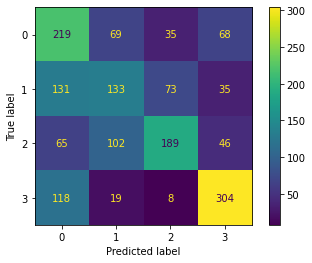

In [21]:
## parameters for performing gridsearch

grid_parameters = {
    'classifier__hidden_layer_sizes':   np.arange(25,100,15),
    'classifier__solver' :              ['sgd','adam'],
    'classifier__activation' :          ['relu'],
    'classifier__learning_rate' :       ['constant', 'adaptive'],
    'classifier__learning_rate_init' :  [0.1,0.2,0.3, 0.4,0.5],
    'classifier__early_stopping' : [True]
    
}

# Calling the function gridsearch with KNeighborsClassifier,grid_parameters and Cross validator,saving the model in a variable.
model = gridsearch(MLPClassifier(),grid_parameters,cv)

## Printing best parameters given by gridsearch 
print("Best parameters : ", model.best_params_, " \n")

## printing train accuracy
print("Training Accuracy :   ", model.best_score_)

## Making predictions on validation data
y_predicted = model.best_estimator_.predict(X_validation)

## Calculating accuracy score on validation data
accuracy_MLP = accuracy_score(y_validation, y_predicted)
print("Validation Accuracy : ", (accuracy_MLP),  "\n ")

## priting confusion matrix to evaluate the accuracy of classification.
cm_MLP = confusion_matrix(y_validation, y_predicted)
print("Confusion Matrix: \n",cm_MLP)
disp = ConfusionMatrixDisplay(cm_MLP)
disp.plot()

## printing Classification Report: A text report showing the main classification metrics.
print(" ")
print("Classification Report : \n", classification_report(y_validation, y_predicted))

## Saving the best estimator
Best_estimator_MLP =  model.best_estimator_

# MLPClassifier

# Comparing the performance of different models built

In [35]:

## creating a dictionay of models with classifier names and corresponding validation accuracy of each classifier
models= {
           
            "KNeighbors Classifier"  : [accuracy_knn],
            "LogisticRegression"     : [accuracy_logistic],
            "SVC"                    : [accuracy_svc],
            "MLP"                    : [accuracy_MLP]
            
            }

# Creating a datframe with models dictionary
results = pd.DataFrame(models,index=['Accuracy']).transpose()
results

,Accuracy
KNeighbors Classifier,0.498761
LogisticRegression,0.525403
SVC,0.542131
MLP,0.523544


<AxesSubplot:>

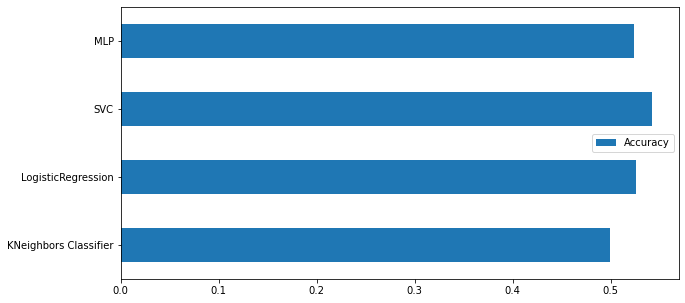

In [88]:
# Plotting bar graph to compare the accuracies of models 

results.plot.barh(figsize=(10,5))

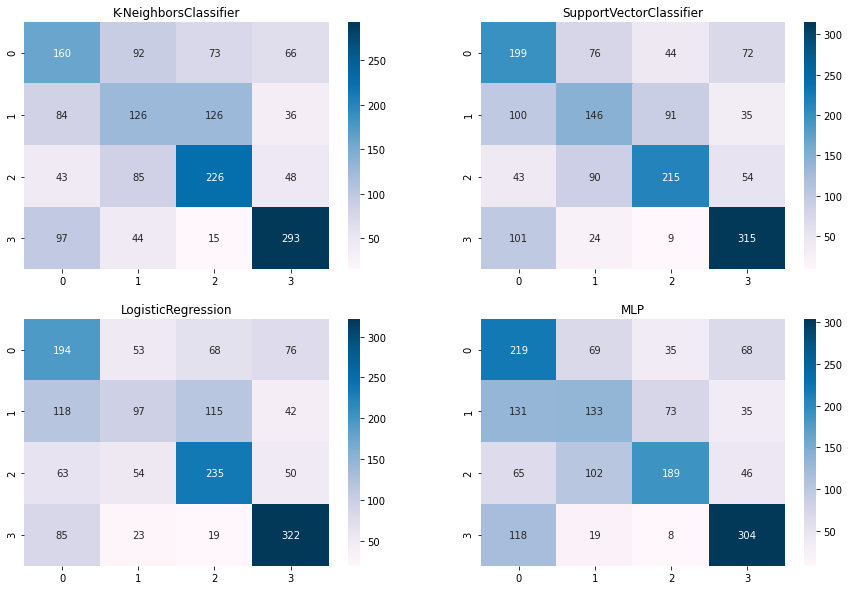

In [38]:
plt.figure(figsize=(15,10))
plt_number = 1
confusion_matrices = [cm_knn,cm_svc,cm_logistic,cm_MLP]
matrix_names = ['K-NeighborsClassifier','SupportVectorClassifier','LogisticRegression','MLP']

for matrix,matrix_name in zip(confusion_matrices ,matrix_names):
    if plt_number <= 4:
        ax = plt.subplot(2,2,plt_number)
        sns.heatmap(matrix, annot=True,fmt='d',cmap='PuBu')
        plt.title(matrix_name)
    plt_number+=1

# Predictions on Test Data¶

In [40]:
# Reading the given test dataset into pandas dataframe
test_data = pd.read_csv("Test.csv")

## Displaying the first 5 rows of data
test_data.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,B
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,A
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,A
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,B
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,A


In [70]:
test_data.Segmentation = test_data.Segmentation.map({'A':1,'B':2,'C':3,'D':4})
test_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,2
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,1
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,1
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,2
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,1


In [74]:
# storing target column in variable called y
y_test = test_data.Segmentation

# Storing all the columns otherthan target in variable called X
X_test = test_data.drop(columns = 'Segmentation')

In [72]:
Best_estimator_svc

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['Age', 'Work_Experience', 'Family_Size'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                 

In [75]:
## Predicting the class labels of test data using the best model chosen 
## SVC showed highest accuracy of 54% and using that model, we are predicting class labels of test data

predictions = Best_estimator_svc.predict(X_test)
#Class_predictions = pd.Series(Class_predictions)
#Class_predictions
predictions

array([1, 3, 1, ..., 1, 2, 4], dtype=int64)

In [78]:
from sklearn import metrics
metrics.accuracy_score(y_test,predictions)

0.33764750666159116

In [80]:
# Alternatively we can save the model to the local file system for deployment
import pickle
filename = 'Customer_segments.pickle'
pickle.dump(Best_estimator_svc, open(filename, 'wb'))